In [1]:
import proplot as plot
import numpy as np
import yaml
import glob

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "WARNING"))

In [3]:
import tempfile
import tqdm

from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE

In [8]:
def run_sim_from_config(glob_pth, master_seed, pa_max=0, layout='grid', bad_columns=None):
    with open(glob.glob(glob_pth)[0]) as fp:
        cfg = yaml.safe_load(fp.read())
    
    cfg["se"]["wcs_config"]["position_angle_range"] = [0, pa_max]
    cfg["layout"]["type"] = layout
    if bad_columns is not None:
        cfg["msk"]["bad_columns"] = bad_columns
    cfg["msk"]["streaks"] = True
    cfg["pizza_cutter"]["single_epoch_config"]["spline_interp_flags"] = [7]

    seeds = np.random.RandomState(seed=master_seed).randint(low=1, high=2**29, size=3)
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            **data,
        )
    return data, cdata

Text(0.5, 1.0, '0020')

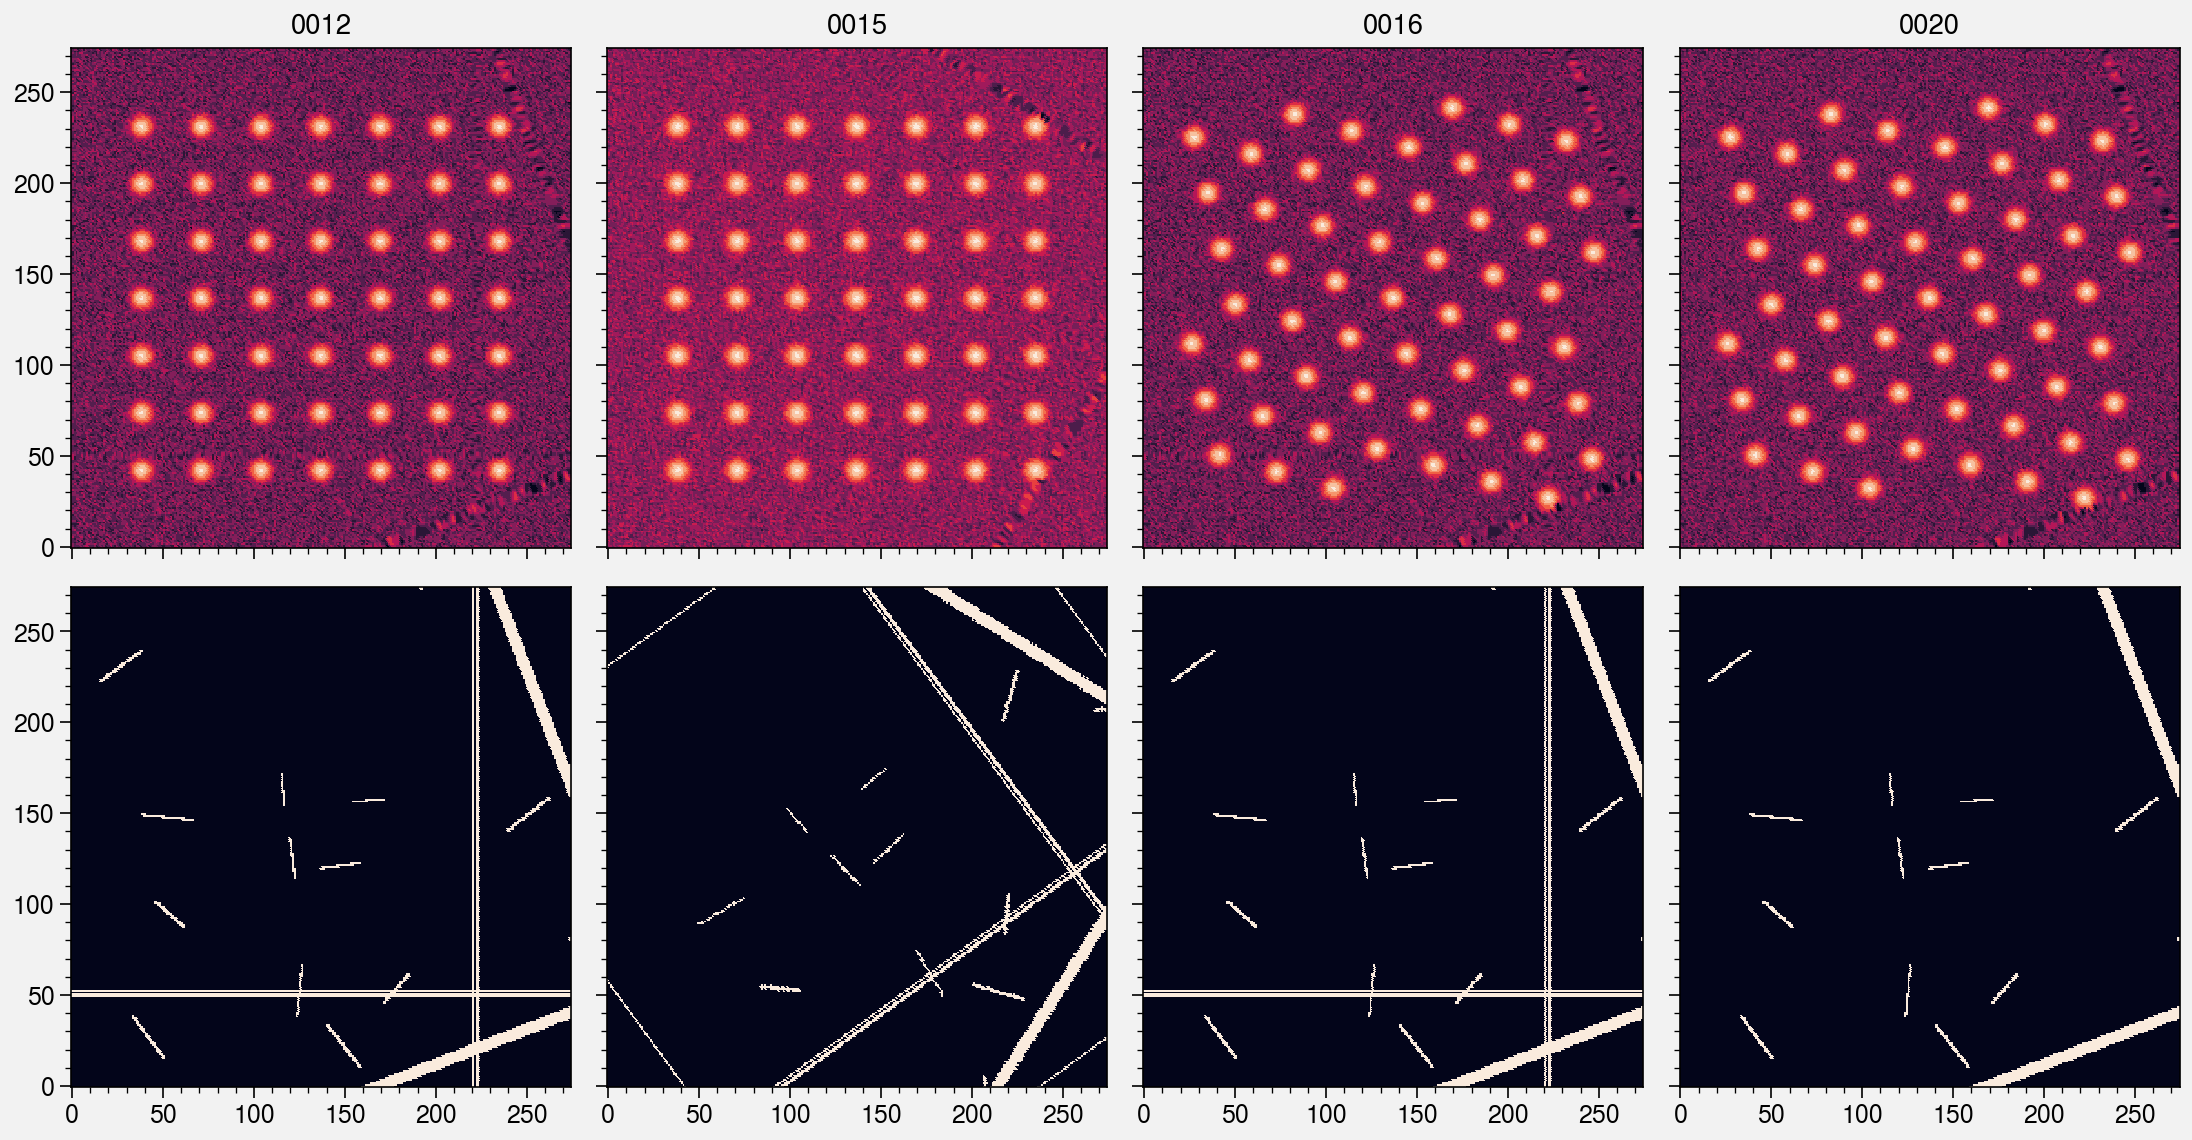

In [12]:
seed = 56
fig, axs = plot.subplots(nrows=2, ncols=4)

cdata = run_sim_from_config("../runs/run0012_*/config.yaml", seed)[1]
axs[0, 0].pcolormesh(
    np.arcsinh(cdata["image"]*np.sqrt(cdata["weight"])), 
    cmap="rocket",
)
axs[1, 0].pcolormesh(cdata["bmask"], cmap="rocket")
axs[0, 0].set_title("0012")

cdata = run_sim_from_config("../runs/run0012_*/config.yaml", seed, pa_max=365)[1]
axs[0, 1].pcolormesh(
    np.arcsinh(cdata["image"]*np.sqrt(cdata["weight"])), 
    cmap="rocket",
)
axs[1, 1].pcolormesh(cdata["bmask"], cmap="rocket")
axs[0, 1].set_title("0015")

cdata = run_sim_from_config("../runs/run0012_*/config.yaml", seed, layout='hex')[1]
axs[0, 2].pcolormesh(
    np.arcsinh(cdata["image"]*np.sqrt(cdata["weight"])), 
    cmap="rocket",
)
axs[1, 2].pcolormesh(cdata["bmask"], cmap="rocket")
axs[0, 2].set_title("0016")

cdata = run_sim_from_config("../runs/run0012_*/config.yaml", seed, layout='hex', bad_columns=False)[1]
axs[0, 3].pcolormesh(
    np.arcsinh(cdata["image"]*np.sqrt(cdata["weight"])), 
    cmap="rocket",
)
axs[1, 3].pcolormesh(cdata["bmask"], cmap="rocket")
axs[0, 3].set_title("0020")